Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10:
  Training Loss: 1.5569
  Training Accuracy: 0.4283
Epoch 2/10:
  Training Loss: 1.2305
  Training Accuracy: 0.5550
Epoch 3/10:
  Training Loss: 1.0893
  Training Accuracy: 0.6128
Epoch 4/10:
  Training Loss: 0.9942
  Training Accuracy: 0.6462
Epoch 5/10:
  Training Loss: 0.9244
  Training Accuracy: 0.6731
Epoch 6/10:
  Training Loss: 0.8816
  Training Accuracy: 0.6897
Epoch 7/10:
  Training Loss: 0.8420
  Training Accuracy: 0.7037
Epoch 8/10:
  Training Loss: 0.8125
  Training Accuracy: 0.7140
Epoch 9/10:
  Training Loss: 0.7749
  Training Accuracy: 0.7302
Epoch 10/10:
  Training Loss: 0.7561
  Training Accuracy: 0.7361


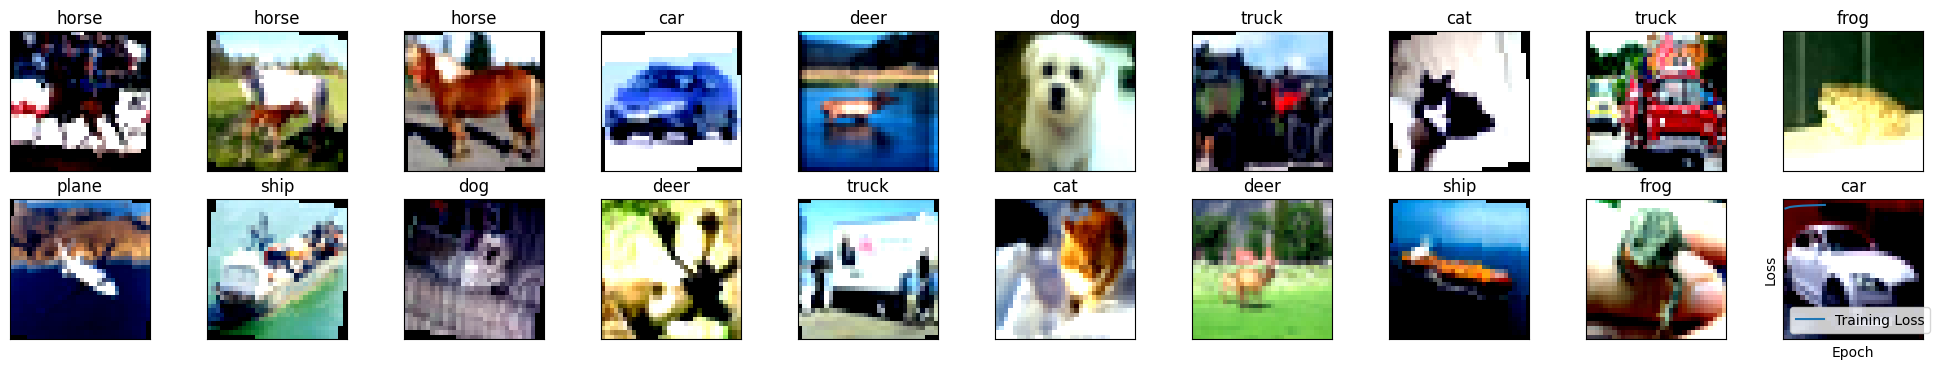

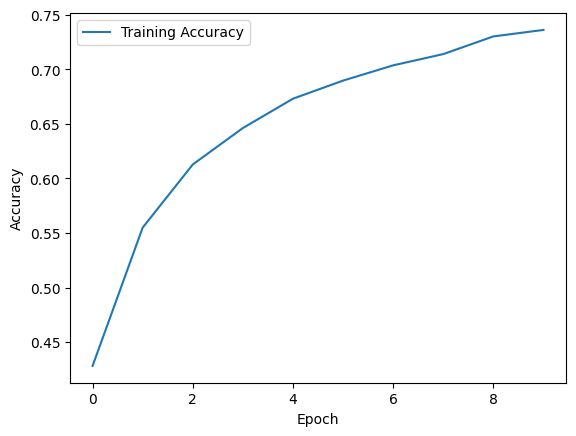

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, ToPILImage, RandomRotation
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import numpy as np
from torchvision.transforms import RandomHorizontalFlip
import torch.optim as optim


# Setting up the transforms for data augmentation
transform_train = Compose([
    Resize((32, 32)),
    RandomRotation(10),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

transform_val = Compose([
    Resize((32, 32)),
    ToTensor(),
    Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Creating the training and validation datasets
training_dataset = CIFAR10(root='data/', train=True, download=True, transform=transform_train)
validation_dataset = CIFAR10(root='data/', train=False, download=True, transform=transform_val)

# Creating data loaders
batch_size = 100
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Function to convert tensor to image
def tensor_to_image(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

# Classes in CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Displaying sample images from the training dataset
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(tensor_to_image(images[idx]))
    ax.set_title(classes[labels[idx].item()])

# Defining the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the LeNet model
model = LeNet().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
num_epochs = 10

# Lists to store the training loss and accuracy
train_loss_history = []
train_acc_history = []

# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0.0
    total = 0

    model.train()  # Set the model to training mode

    # Iterate over the training dataset in batches
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate the average training loss and accuracy for the epoch
    avg_train_loss = train_loss / total
    avg_train_acc = train_correct / total

    # Append the loss and accuracy to the respective lists
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)

    # Print the epoch number, loss, and accuracy
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Training Accuracy: {avg_train_acc:.4f}")

# Plot the training loss and accuracy
plt.plot(train_loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_acc_history, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

